In [1]:
import os
import warnings
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, fbeta_score,confusion_matrix, roc_curve,auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline



os.chdir('../')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/pre-model/data.csv')

In [3]:
X, y  = df.drop('Estado del egreso', axis = 1), df['Estado del egreso']

In [4]:
models = [
    LogisticRegression(random_state=1),
    RandomForestClassifier(random_state=1),
    SVC(kernel='linear', random_state=1),
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [5]:
for model in models:
    results = cross_val_score(model, X, y, scoring='f1', cv=skf)
    print(results.mean(), results.std())

0.9264335664335664 0.07364987689712528
0.877948717948718 0.12848789329942079
0.9264335664335664 0.07364987689712528


In [ ]:
params_lr_new = {
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500],
    'class_weight': ['balanced', None],
    'l1_ratio': [0.5]
}

In [8]:
lr = LogisticRegression(random_state=1)

In [9]:
grid = GridSearchCV(lr, params_lr_new, scoring= 'f1', cv=skf)
grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None], 'l1_ratio': [0.5],
                         'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [10]:
grid.best_score_

0.9418181818181818

In [11]:
best = grid.best_estimator_

In [25]:
grid.best_params_

{'C': 10,
 'class_weight': None,
 'l1_ratio': 0.5,
 'max_iter': 500,
 'penalty': 'l2',
 'solver': 'saga'}

In [12]:
joblib.dump(best, 'models/lr.joblib')

['models/lr.joblib']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best.fit(X_train, y_train)




LogisticRegression(C=10, l1_ratio=0.5, max_iter=500, random_state=1,
                   solver='saga')

In [14]:
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

In [15]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[13  0]
 [ 1  5]]


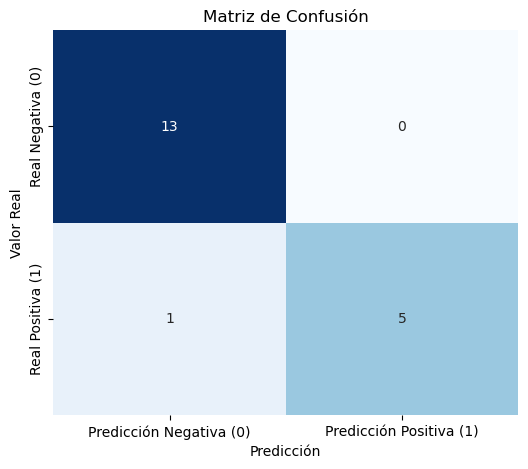

In [16]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicción Negativa (0)', 'Predicción Positiva (1)'],
            yticklabels=['Real Negativa (0)', 'Real Positiva (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

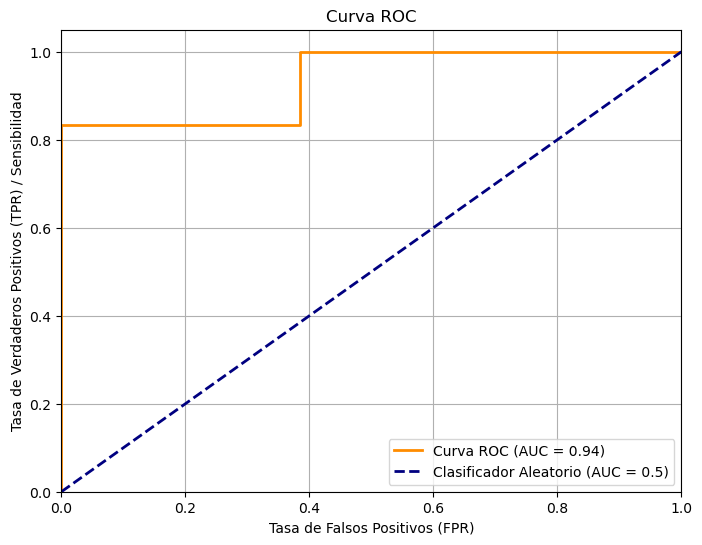

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Sensibilidad')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [19]:
print(f"Área bajo la curva ROC (AUC): {roc_auc:.4f}")

Área bajo la curva ROC (AUC): 0.9359


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9474
Precision: 1.0000
Recall: 0.8333
F1-score: 0.9091
